In [34]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [36]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions', 'property_address_schools']


In [37]:
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1477830, 37)
(709325, 22)


In [38]:
pp = Preprocess(df_transaction, df_property, target='sold_price')

In [39]:
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features_base = list(set(use_features) - set(school_features))
use_features_base

['sold_price_zip_avg',
 'lat',
 'sqft_over_zip_avg',
 'eval_over_zip_avg',
 'pool',
 'pin',
 'sqft_zip_avg',
 'sqft',
 'sqft_price_zip_avg',
 'impr_over_land',
 'num_bath',
 'date',
 'view',
 'lon',
 'num_bed',
 'eval_zip_avg']

In [40]:
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(69026, 27)


,high_rating,lat,avg_high_rating,sqft,middle_rating,id,min_high_distance,pool,sqft_zip_avg,sold_price,...,lon,num_bed,avg_middle_rating,eval_zip_avg,min_middle_distance,sqft_over_zip_avg,impr_over_land,num_bath,view,avg_elem_rating
0,5.00,32.57141,5.000000,1008,6.0,1395276,588.900513,0,1314.809291,445000,...,-117.10905,3.0,6.000000,499326.537897,1252.112571,0.766651,1.225000,2.0,0,4.000000
13255,7.00,32.75133,6.466667,1274,7.0,1395290,2222.612139,0,1769.504702,315000,...,-116.94223,3.0,5.259259,481237.685737,969.465776,0.719975,1.739916,2.0,1,7.000000
62047,8.25,32.74473,8.250000,840,5.0,1395392,1653.725193,0,1402.442574,340000,...,-117.15826,2.0,7.416667,709445.015842,1023.326852,0.598955,2.087515,1.0,0,8.333333
62046,8.25,32.74451,8.250000,864,5.0,1395384,1814.643056,0,1402.442574,375000,...,-117.16051,1.0,7.333333,709445.015842,1202.902514,0.616068,2.160235,1.0,0,8.000000
61202,NaN,33.10266,NaN,2456,NaN,1395387,NaN,0,2163.965680,950000,...,-117.30830,4.0,NaN,825232.724260,NaN,1.134953,0.889355,3.0,0,NaN


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [41]:
df_track.isnull().sum()

high_rating            8017
lat                       0
avg_high_rating        7865
sqft                      0
middle_rating          5958
id                        0
min_high_distance      7985
pool                      0
sqft_zip_avg              0
sold_price                0
min_elem_distance      2490
sold_price_zip_avg        0
elem_rating            2501
eval_over_zip_avg         0
pin                       0
sqft_price_zip_avg        0
date                      0
lon                       0
num_bed                   0
avg_middle_rating      5838
eval_zip_avg              0
min_middle_distance    4538
sqft_over_zip_avg         0
impr_over_land            0
num_bath                  0
view                      0
avg_elem_rating        2501
dtype: int64

In [42]:
### baseline without school features
rf = RandomForestRegressor(n_estimators=100, max_depth=16, n_jobs=-1, random_state=17)
mm = ModelManager(df_track, use_features_base, rf, target='sold_price', time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57522, 34512, 11504
[dp] training data size: (34512, 14)
[dp] test data size: (11504, 14)


119267.58947030158

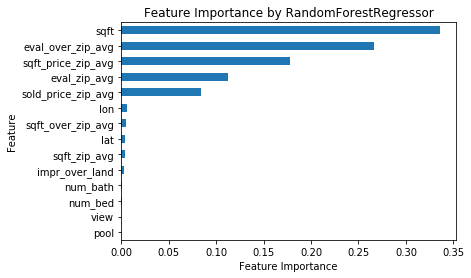

In [43]:
mm.plot_feature_importance()

In [45]:
### fill school feature nan with mean
df_track_valid = df_track.fillna(df_track.mean())
mm1 = ModelManager(df_track_valid, use_features, rf, target='sold_price', time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57522, 34512, 11504
[dp] training data size: (34512, 23)
[dp] test data size: (11504, 23)


118852.60211856647

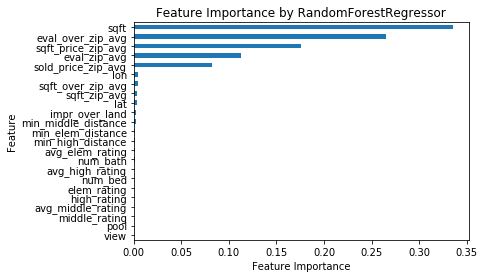

In [46]:
mm1.plot_feature_importance()

In [50]:
### fill school feature nan with extreme value
df_track_valid = df_track.copy()
for f in ['min_elem_distance', 'min_middle_distance', 'min_high_distance']:
    df_track_valid[f] = df_track_valid[f].fillna(df_track_valid[f].max())
df_track_valid = df_track_valid.fillna(0)
mm2 = ModelManager(df_track_valid, use_features, rf, target='sold_price', time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57522, 34512, 11504
[dp] training data size: (34512, 23)
[dp] test data size: (11504, 23)


118631.21027919654

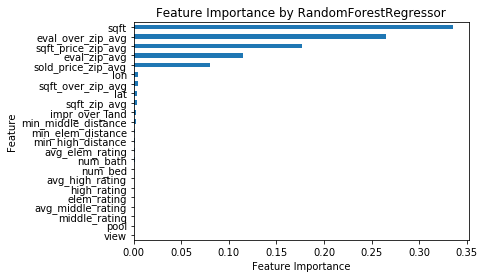

In [51]:
mm2.plot_feature_importance()

In [52]:
### remove rows with invalid school feature value
df_track_valid = df_track[np.isfinite(df_track['min_elem_distance']) & 
                          np.isfinite(df_track['min_middle_distance']) &
                          np.isfinite(df_track['min_high_distance']) &
                          np.isfinite(df_track['elem_rating']) &
                          np.isfinite(df_track['middle_rating']) &
                          np.isfinite(df_track['high_rating']) 
                         ]
mm3 = ModelManager(df_track_valid, use_features, rf, target='sold_price', time_series=True)
mm3.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 47071, 34512, 11504
[dp] training data size: (34512, 23)
[dp] test data size: (11504, 23)


106268.42182590491

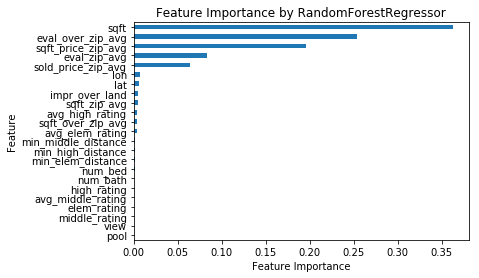

In [53]:
mm3.plot_feature_importance()